## __Predicción de eclipses asistida por Machine Learning__

<!-- Durante toda nuestra vida, y desde los inicios mismos de nuestra historia, convivimos con este interesante y notorio fenómeno que, durante mucho tiempo, dio lugar a curiosas e interesantes historias que intentaban explicar su funcionamiento. Hoy, entendemos plenamente su funcionamiento, y, a forma de corolario de la comprensión de la mecánica celeste, somos capaces de predecirlo de forma precisa para nuestro ocio o para usarlo en investigación científica, como se hizo en 1919 para someter a prueba por primera vez la Relatividad General de Einstein.

A pesar de la fuerte comprensión teórica que se tiene actualmente sobre ese y otros fenómenos de la mecánica celeste, resulta difícil a nivel de cálculos y poder de cómputo, desarrollar algoritmos eficientes basados en nuestras teorías que sean capaces de, al mismo tiempo, obtener predicciones precisas y obtener resultados en tiempos de cómputo racionales. Por otro lado, con el actual desarrollo en el campo de la computación y el Aprendizaje Automático (Inteligencia Artificial), se ha notado que, bajo este paradigma, es posible entrenar modelos de aprendizaje que replican de forma correcta, y en tiempos de cálculo mucho más razonables, teorías y leyes físicas de nuestro universo, resultando en modelos de gran interés cuando se quiere replicar la realidad física de forma rápida (como se requiere por ejemplo en el campo de gráficos por computadora). 

Es así, como M. Sferdian, M. Frincu (2021) (https://irep.ntu.ac.uk/id/eprint/44130/), muestran la mejora computacional obtenida entre el métodos clásico implementado en un algoritmo de fuerza bruta, y el entrenamiento de un modelo de Machine Learning para la predicción de eclipses. En el trabajo actual, se replica el trabajo hecho en el artículo para entrenar el modelo de aprendizaje automático. -->

En el trabajo desarollado por nosotros, implementaremos solo los métodos basados en Machine Learning descritos en el artículo original, a ser, K-Nearest Neighbors, Logistic Regression para clasificación, y Random Forest, además un modelo basado en Redes Neuronales para comparar los resultados. De lo anterior, se obtuvo el mejor resultado para el modelo -simple- basado en redes neuronales, y para este modelo se realizó predicciones de eclipses dada una fecha de entrada como cadena de caracteres siguiendo el formato ```YYYY-MM-DD```.

El método descrito en el artículo para la identificación de eclipses (pag. 8, M. Sferdian, M. Frincy (2021)), se basa en los métodos VSOP87 y ELP-2000/82 para la determinación de coordenadas solares y lunares en el cielo. A partir de ellas, se determina, para cada día en el conjunto de datos original, y para distintas locaciones en la esfera terrrestre cada día, la separación mínima entre los dos cuerpos celestes, conociendo sus radios y teniendo en cuenta las condiciones de un eclipse solar y uno lunar (mes sideral y mes dracónico). Este cálculo representa el parámetro de identificación de eclipses basado en machine learning.

### __Implementación de modelos__

Primero haremos la lectura de datos y la definición de los conjuntos de entrenamiento y de prueba. El conjunto de datos original contiene información desde el año 1999 a.C, hasta el año 2100 d.C, estos datos son obtenidos de bases de datos de la NASA (https://eclipse.gsfc.nasa.gov/) y datos meteorológicos (http://www.timeanddate.com/eclipse/list.html) que comprenden un conjunto de eclipses solares y lunares desde el año 1999 a.C hasta el año 2100 d.C.
Para el entrenamiento de nuestros modelos, usaremos un subconjunto del conjunto de datos inicial, que es, a su vez, un subconjunto del los datos originales de la NASA organizados por los autores originales. Estos conjuntos de datos se dividen como se describe a continuación.

##### __Conjunto de entrenamiento__
Consiste en datos de eclipses solares desde el primero de enero de 1950 (```1950-01-01```), hasta datos del treinta y uno de diciembre de 2019 (```2019-12-31```). En estos datos se puede corroborar la congruencia con los datos observacionales, como el pasado eclipse del 14 de octubre del 2023.

#### __Conjunto de prueba__
El conjunto de prueba consiste el resto de datos de eclipses solares, desde el primero de enero del 2020 hasta el 31 de diciembre del 2100. Aquí, igualmente, se puede corroborar la congruencia de los datos al comparar con, por ejemplo, los futuros eclipses para el 8 de abril de 2024 y el 29 de marzo de 2025.

Con estos conjuntos de prueba, implementaremos los distintos modelos de Machine Learning utilizando las implementaciones en la librería ```scikit-learn```. Los resultados obtenidos se discuten luego de las implementaciones realizadas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from include.Calculations.aux_funcs import get_minimum_separation, get_minimum_separation_lunar
from include.ML.confusion_matrix_helper import make_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ===============================================Data retrieval==================================================
# check that the data is already installed in local directory (execute include/get_data.py and check that all the 
# files in data were correctly installed)

# ===============================================solar eclipses==================================================

df = pd.read_csv('data/solar-eclipses-classif.csv')
df['Is Eclipse'] = df['Is Eclipse'].replace({True: 1, False: 0})
# ===============================================lunar eclipses==================================================

dfl = pd.read_csv('data/lunar-eclipses-classif.csv')
dfl['Is Eclipse'] = dfl['Is Eclipse'].replace({True: 1, False: 0})

# ===============================================relation between data===========================================
true = df[df['Is Eclipse'] == 1].shape[0] # solar
false = df[df['Is Eclipse'] == 0].shape[0]
truel = dfl[dfl['Is Eclipse'] == 1].shape[0] # lunar
falsel = dfl[dfl['Is Eclipse'] == 0].shape[0]

In [3]:
# ===============================================data preparation================================================
bias_pos = df[df['Date'] == '2019-12-31'].index.item() + 1 # sets the position of the given Date as bias for the training set
train, test = df[:bias_pos], df[bias_pos:]
train_labels, test_labels = np.array(train.pop('Is Eclipse')), np.array(test.pop('Is Eclipse'))
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
train, test = train.select_dtypes('number'), test.select_dtypes('number')

print(f'Number of solar eclipses in subset: {true}')
print(f'Number of no solar eclipses in subset: {false}')
print(f'Estimated total number of events in the sample: {true+false}')
print(f'Actual total: ', df['Is Eclipse'].shape[0])
print(f'Relation true/whole: {100 * true/(true+false):.2f}%\n')

print(f'Number of solar eclipses in test: {np.count_nonzero(test_labels == 1)}')
print(f'Number of no solar eclipses in test: {np.count_nonzero(test_labels == 0)}')

Number of solar eclipses in subset: 337
Number of no solar eclipses in subset: 54815
Estimated total number of events in the sample: 55152
Actual total:  55152
Relation true/whole: 0.61%

Number of solar eclipses in test: 182
Number of no solar eclipses in test: 29403


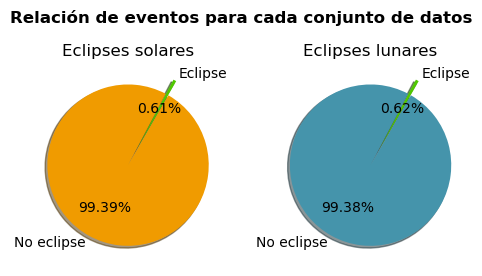

In [4]:
# ==================================================plotting=====================================================
fig, ax = plt.subplots(1,2, figsize = (5,3.5))

fig.suptitle('Relación de eventos para cada conjunto de datos', fontweight = 'bold', y = 0.9)
ax[0].set_title('Eclipses solares')
ax[0].pie([true, false], labels = ['Eclipse', 'No eclipse'],
        shadow = True,
        autopct = '%1.2f%%',
        explode = (0.2,0),
        colors = ['#50c800', '#f09b00'],
        startangle = 60
        )
ax[1].set_title('Eclipses lunares')
ax[1].pie([truel, falsel], labels = ['Eclipse', 'No eclipse'],
        shadow = True,
        autopct = '%1.2f%%',
        explode = (0.2,0),
        colors = ['#50c800', '#4594ab'],
        startangle = 60
        )
plt.tight_layout()
# plt.savefig('figures/pie_chart.pdf')

In [5]:
# aux function to plot confusion matrix. This function uses the implementation made by the originals authors to plot de confusion matrix but it
# has slight changes made by us
def plot_cf_matrix(test_labels, predictions, accuracy, f1, label = '', cmap = 'Reds', figsize = (5,5)):
    cf_matrix = confusion_matrix(test_labels, predictions)
    labels = ['True Negatives','False Positives','False Negatives','True Positives']
    categories = ['No eclipse', 'Elipse']
    make_confusion_matrix(cf_matrix,
                        accuracy = accuracy,
                        f1 = f1,
                        group_names = labels,
                        categories = categories,
                        cbar = False,
                        title = 'Confusion Matrix (' + label + ')',
                        cmap = cmap,
                        figsize = figsize)

### __K-Nearest Neighbors__
El agoritmo K-NN es un algoritmo no supervisado de agrupación de datos, y será la primera implementación que haremos. Los parámetros establecidos antes del entrenamiento del modelo, son resultado de prueba y error hasta obtener una buena precisión. Algunos datos son dejados como el valor por defecto implementado en la librería.

Model Score: 0.9991887780970086
Model Accuracy: 0.9991887780970086
Precision: 0.895
Recall: 0.9835164835164835
F1 Score: 0.9371727748691099


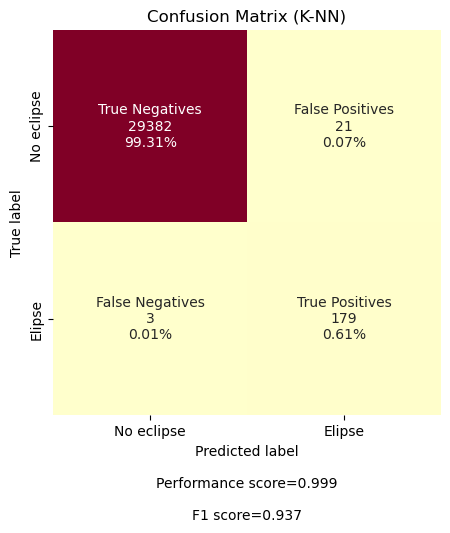

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(algorithm = 'auto',
    leaf_size = 30,
    metric = 'minkowski',
    n_neighbors = 7,
    p = 2,
    weights = 'uniform'
)
knn_model.fit(train, train_labels)

# =====================================================METRICS================================================
predictions_knn = knn_model.predict(test)
accuracy_knn = knn_model.score(test, test_labels)
f1_knn = f1_score(test_labels, predictions_knn)
print(f'Model Score: {knn_model.score(test, test_labels)}')
print(f'Model Accuracy: {accuracy_knn}')
print(f'Precision: {precision_score(test_labels, predictions_knn)}')
print(f'Recall: {recall_score(test_labels, predictions_knn)}')
print(f'F1 Score: {f1_knn}')
plot_cf_matrix(test_labels, predictions_knn, accuracy_knn, f1_knn, label = 'K-NN', cmap = 'YlOrRd')
# plt.tight_layout()
# plt.savefig('figures/knn.pdf')

### __Logistic Regression__
La regresión logística resulta ser, en este caso, una aproximación más natural al problema, dado el sistema de clasificación binaria al que apuntamos. En esta implementación todos los parámetros se dejaron iguales a los parámetros por defecto en la librería.

Model Accuracy: 0.9989183707960115
Precision: 0.8947368421052632
Recall: 0.9340659340659341
F1 Score: 0.913978494623656


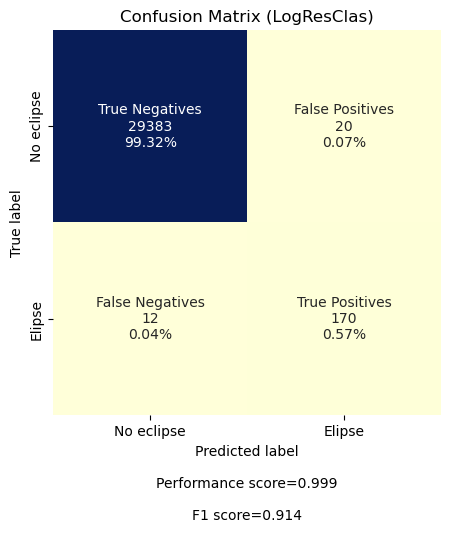

In [7]:
from sklearn.linear_model import LogisticRegression
logclas_model = LogisticRegression()
logclas_model.fit(train, train_labels)

# =====================================================METRICS================================================
predictions_lr = logclas_model.predict(test)
accuracy_lr = logclas_model.score(test, test_labels)
f1_lr = f1_score(test_labels, predictions_lr)
print(f'Model Accuracy: {accuracy_lr}')
print(f'Precision: {precision_score(test_labels, predictions_lr)}')
print(f'Recall: {recall_score(test_labels, predictions_lr)}')
print(f'F1 Score: {f1_lr}')
plot_cf_matrix(test_labels, predictions_lr, accuracy_lr, f1_lr, label = 'LogResClas', cmap='YlGnBu')
# plt.tight_layout()
# plt.savefig('figures/lr.pdf')

### __Random Forest Classifier__
De la misma forma que para la clasificación logística, el algoritmo de bosques aleatorios resulta una aproximación más natural al problema, así como a su vez, una mejora en el algortimo de regresión logística, dados los criterios de comparación empleados. En este caso, parámetros como el número de estimadores, no mostraron mayor relevancia a la hora de ejecutar la clasificación.

Model Accuracy: 0.9991887780970086
Precision: 0.895
Recall: 0.9835164835164835
F1 Score: 0.9371727748691099


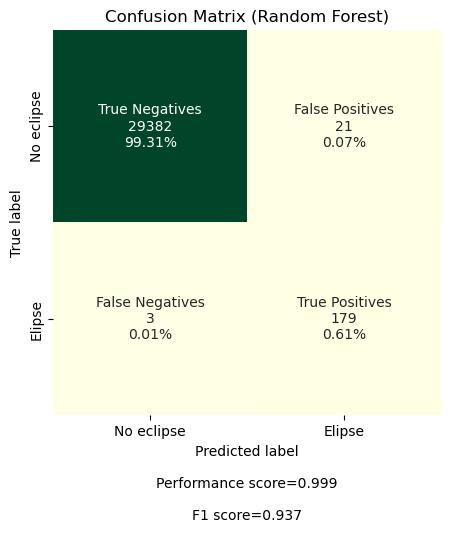

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=50, 
    criterion='gini', 
    max_depth=2, # no overfitting
    min_samples_split=30, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)
rf_model.fit(train, train_labels)

# =====================================================METRICS================================================
predictions_rf = rf_model.predict(test)
accuracy_rf = rf_model.score(test, test_labels)
f1_rf = f1_score(test_labels, predictions_rf)
print(f'Model Accuracy: {accuracy_rf}')
print(f'Precision: {precision_score(test_labels, predictions_rf)}')
print(f'Recall: {recall_score(test_labels, predictions_rf)}')
print(f'F1 Score: {f1_rf}')
plot_cf_matrix(test_labels, predictions_rf, accuracy_rf, f1_rf, label = 'Random Forest', cmap = 'YlGn')
# plt.tight_layout()
# plt.savefig('figures/rf.pdf')

### __Multi-layer Perceptron Classifier__
Finalmente, hacemos uso de un algoritmo de clasificación basado en redes neuronales con 5 capas ocultas de 5, 8 y 8 neuronas respectivamente, haciendo uso de la función de activación ```relu``` y el algoritmo de optimización ```adam```. Este número de capas y de neuronas son escogidas a través de prueba y error para obtener un modelo eficiente. Dada la naturaleza de los algoritmos basados en redes neuronal, podemos esperar que esta optimización sea buena, pero no podemos, apriori, estimar qué tanto respecto a los otros métodos.

Model Accuracy: 0.9988507689707622
Precision: 0.8936170212765957
Recall: 0.9230769230769231
F1 Score: 0.908108108108108


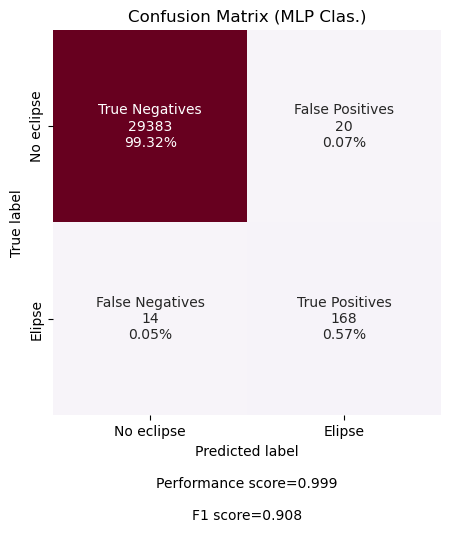

In [9]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(5,8,8), 
    activation='relu', 
    solver='adam', 
    max_iter=500)
mlp_model.fit(train,train_labels)

# =====================================================METRICS================================================
predictions_mlp = mlp_model.predict(test)
accuracy_mlp = mlp_model.score(test, test_labels)
f1_mlp = f1_score(test_labels, predictions_mlp)
print(f'Model Accuracy: {accuracy_mlp}')
print(f'Precision: {precision_score(test_labels, predictions_mlp)}')
print(f'Recall: {recall_score(test_labels, predictions_mlp)}')
print(f'F1 Score: {f1_mlp}')
plot_cf_matrix(test_labels, predictions_mlp, accuracy_mlp, f1_mlp, label = 'MLP Clas.', cmap='PuRd')
# plt.tight_layout()
# plt.savefig('figures/mlp.pdf')

### __Resultados__
Dada la relación que se tiene entre eventos etiquetados como verdaderos (eclipses) y eventos etiquetados como falsos (no eclipses), cuya relación es de aproximadamente $99.4\%$ a $0.6\%$, las métricas de evaluación de cada modelo presentan un sesgo, donde la métrica está fuertemente ponderada hacia la identificación de verdaderos negativos (TN), es decir, eventos "no eclipse" que fueron identificados como tal. Como el propósito del algoritmo es identificar eclipses y no "no eclipses", las métricas como tal no representarán un criterio determinante a la hora de analizar los resultados.

Dicho lo anterior, nos fijaremos, en cada caso, en la cantidad de verdaderos positivos (TP) de cada modelo. Podemos comparar la cantidad de eventos identificados como tal, y comparar respecto al total de eventos disponibles en el conjunto (182 eclipses, en el caso del conjunto de prueba para eclipses solares).

Bajo estos criterios, los modelos que mejor se comportaron fueron los modelos de K-Nearest Neighbors, y Random Forest Classifier. Como se puede apreciar a partir de las matrices de confusión en cada caso, cada algoritmo tuvo una precisión del $98.4\%$ en la identificación de verdaderos positivos (TP), identificando $179$ de los $182$ eventos identificados como eclipses. Además del rendimiento identificando eventos verdaderos, los algoritmos presentan un buen rendimiento idenficando falsos positivos (FP) y falsos negativos (FN); esta métrica varía para el caso del método basado en Random Forest, presentando un rendimiento ligeramente inferior al modelo K-NN, donde se obtiene, respectivamente 3 FN y 23FP (RF), contra 3FN y 21FP (K-NN), esta métrica, presenta variaciones y puede resultar en los mismos resultados para ambos modelos (3FN, 21FP).

Del entrenamiento, el método basado en Redes Neuronales (MLP Classifier) y el método de Regresión Logística (Logistic Regression), resultaron en implementaciones con un menor rendimiento. El métododo MLP presenta, al igual que RF, ciertas variaciones al momento de realizar dos entrenamientos con los mismos datos, obteniendo, según lo observado, un rendimiento de entre el $90.7\%$ y el $94.5\%$ en la identificación de verdaderos positivos.

### __Predicciones__

Podemos usar la función ```get_separtion()``` para, dada una fecha, predecir si en ese día ocurrirá o no un eclipse. Anque el entrenamiento se hizo para datos de eclipses solares, podemos también probar la precisión de los métodos para identificar eclipses lunares, haciendo uso de la función ```get_separation_lunar()```.

Inicialmente, probemos el rendimiento del modelo para identificar los dos eclipses más próximos a la fecha de elaboración de este trabajo (octubre de 2023)

In [10]:
date = '2023-10-14' # solar
print(knn_model.predict([[get_minimum_separation(date)]]))
print(logclas_model.predict([[get_minimum_separation(date)]]))
print(rf_model.predict([[get_minimum_separation(date)]]))
print(mlp_model.predict([[get_minimum_separation(date)]]))

[1]
[1]
[1]
[1]


In [11]:
date = '2024-04-08' # solar
print(knn_model.predict([[get_minimum_separation(date)]]))
print(logclas_model.predict([[get_minimum_separation(date)]]))
print(rf_model.predict([[get_minimum_separation(date)]]))
print(mlp_model.predict([[get_minimum_separation(date)]]))

[1]
[1]
[1]
[1]


In [31]:
# date = '2025-03-29' #solar
# print(mlp_model.predict([[get_minimum_separation(date)]]))

En ambos casos de obtiene un buen rendimiento, obteniendo predicciones correctas a partir de todos los modelos.
Un caso de interés, por su importancia histórica, y por hacer parte de un conjunto de datos que no corresponde siquiera al conjunto de datos de entrenamiento, corresponde al ya mencionado eclipse solar del 29 de mayo del 1919. Para este caso, obtenemos los modelos se comportan de la siguiente manera


In [12]:
date = '1919-05-29' # Einstein's eclipse
print(knn_model.predict([[get_minimum_separation(date)]]))
print(logclas_model.predict([[get_minimum_separation(date)]]))
print(rf_model.predict([[get_minimum_separation(date)]]))
print(mlp_model.predict([[get_minimum_separation(date)]]))

[1]
[1]
[1]
[1]


Para cuyo caso obtenemos una predicción correcta para todos los modelos.

Sin embargo, debemos mencionar que la eficiencia del modelo para estos casos se basa en la eficiencia de los métodos de cálculo de separación empleados (```get_minimum_separation()``` y ```get_minimum_separation_lunar()```). Dada esta separación, los algoritmos en sus épocas de entrenamiento son capaces de determinar un valor general como criterio de clasificación de eventos. Es por esto que una implementación más completa del algoritmo, se puede lograr entrenando un modelo de cálculo de separación dada una fecha, usando nuevamente los datos generados aquí (```Date``` y ```Separation```), como datos de entrenamiento y prueba.

Por otro lado, queremos encontrar fallos en los modelos, para esto, buscamos, en los conjuntos de predicciones, los eventos que discrepen de lo reportado inicialmente

In [13]:
# find missings
missedknn = np.where(test_labels - predictions_knn != 0)[0]
missedlr = np.where(test_labels - predictions_lr != 0)[0]
missedrf = np.where(test_labels - predictions_rf != 0)[0]
missedmlp = np.where(test_labels - predictions_mlp != 0)[0]

print('\033[1m' + '-> Position of missed values in test array for (K-NN)' + '\033[0m: \n', missedknn)
print('\033[1m' + '\n-> Position of missed values in test array for (LR)' + '\033[0m: \n', missedlr)
print('\033[1m' + '\n-> Position of missed values in test array for (RF)' + '\033[0m: \n', missedrf)
print('\033[1m' + '\n-> Position of missed values in test array for (MLP)' + '\033[0m: \n', missedmlp)
pos = missedlr[1]

# confirm a miss
print('\nPrediction from model (LR): ', predictions_lr[pos])
print('Actual event: ',test_labels[pos])

# find date of given missing 
missed_date = df['Date'][bias_pos + pos]
print('\nDate of missing: ', missed_date)
print(df[df['Date'] == missed_date])

-> Position of missed values in test array for (K-NN): 
 [ 5547  6933  7967  9179  9533 10212 11954 12633 13165 13697 15940 17151
 18037 22880 23206 23559 24092 25303 25478 26158 27723 28077 28935 29289]

-> Position of missed values in test array for (LR): 
 [ 5547  6048  6933  7967  9179  9533 10211 10212 11954 12633 13165 13697
 14051 15940 16620 17151 18037 20606 20636 22880 23206 24092 24623 25303
 25478 26158 27192 27723 28077 28786 28935 29289]

-> Position of missed values in test array for (RF): 
 [ 5547  6933  7967  9179  9533 10212 11954 12633 13165 13697 15940 17151
 18037 22880 23206 23559 24092 25303 25478 26158 27723 28077 28935 29289]

-> Position of missed values in test array for (MLP): 
 [ 3479  5547  6048  6933  7967  9179  9533 10211 10212 11954 12633 13165
 13697 14021 14051 15940 16620 17151 18037 20606 20636 22880 23206 24092
 24623 25303 25478 26158 27192 27723 28077 28786 28935 29289]

Prediction from model (LR):  0
Actual event:  1

Date of missing:  2036-07-

Para este elemento en nuestro conjunto, confirmamos la predicciones hechas por cada modelo, de donde obtenemos

In [14]:
print('knn prediction: ', knn_model.predict([[get_minimum_separation(missed_date)]]))
print('lr prediction: ', logclas_model.predict([[get_minimum_separation(missed_date)]]))
print('rf prediction: ', rf_model.predict([[get_minimum_separation(missed_date)]]))
print('mlp prediction: ', mlp_model.predict([[get_minimum_separation(missed_date)]]))

knn prediction:  [1]
lr prediction:  [0]
rf prediction:  [1]
mlp prediction:  [0]


Aquí, ambos modelos K-NN y Random Forest, como se mencionó previamente, y como se aprecia en las matrices de confusión, identificaron correctamente el evento, mientras que los modelos de regresión logística, y MLP, fallaron en la identificación.

Ahora, queremos estudiar el comportamiento de estos errores. Para esto, extraigamos la separación que se tiene en estos casos. Dado que el mejor rendimiento, en general se obtiene para el modelo K-NN, extraigamos los valores de separación de estos registros fallidos

In [15]:
separations = np.empty(0)
for elem in missedknn:
    separations = np.append(separations, df.loc[bias_pos + elem, 'Separation'])
    # print(elem)

print('Separations: ', separations)

sorted = np.sort(separations)
print('\nmin value: ', sorted[0])
print('second min value: ', sorted[1])
print('max value: ', sorted[-1])
print('mean: ', np.mean(sorted))
print('standard deviation: ', np.std(sorted))

Separations:  [0.17152778 0.20991667 0.39763889 0.11658333 0.09391667 0.22975
 0.12211111 0.66247222 0.24386111 0.04075    0.44094444 0.27486111
 0.62438889 0.36997222 0.61130556 0.58283333 0.30608333 0.24413889
 0.43983333 0.3665     0.19108333 0.20583333 0.22427778 0.13786111]

min value:  0.04075
second min value:  0.0939166666666666
max value:  0.6624722222222222
mean:  0.3045185185185186
standard deviation:  0.1750615141494057


De lo anterior, podemos notar un comportamiento extraño para el valor mínimo de separación en los eventos fallidos. Obtenemos que el valor mínimo de separación para los eventos fallidos corresponde con una separación de 0.04075, lo que, en principio, debió haber sido catalogado correctamente como un eclipse. Analicemos este valor

In [16]:
rare_pos = np.argmax(separations == sorted[0])
global_pos = missedknn[rare_pos]

# print(rare_pos)
print('Position of the rare value in the initial sample: ', global_pos)
print('Date of the missed prediction: ', df['Date'][bias_pos + global_pos])
print('Prediction made in the initial sample: ', df['Is Eclipse'][bias_pos + global_pos])
print('\nPrediction made one day before in the initial sample (' + df['Date'][bias_pos + global_pos - 1] + '): ', df['Is Eclipse'][bias_pos + global_pos - 1])
print('Separation the day of the actual eclipse (' + df['Date'][bias_pos + global_pos - 1] + '): ', df['Separation'][bias_pos + global_pos - 1])

Position of the rare value in the initial sample:  13697
Date of the missed prediction:  2057-07-02
Prediction made in the initial sample:  0

Prediction made one day before in the initial sample (2057-07-01):  1
Separation the day of the actual eclipse (2057-07-01):  0.2202777777777778


De aquí, vemos que según el conjunto inicial de datos, creado de forma manual aplicando los métodos descritos, el día 2057-07-02 no está predicho ningún eclipse, lo cual es congruente con los registros web (https://www.timeanddate.com/eclipse/solar/2057-july-1). Sin embargo, el día anterior (2057-07-01) sí está registrado un eclipse, el cual está registrado correctamente como eclipse en nuestro conjunto de datos, como se puede ver en la celda anterior. Este último valor tiene una separación de 0.2203 grados, la cual corresponde con una separación en la que nuestro modelo prediciría correctamente, según la predicción hecha previamente para el día 2036-07-23 (0.533139).

Dada esta información, el valor de separación calculado para el día 2057-07-02, corresponde a un valor mal calculado mediante los métodos directos; por lo cual, con la separación para este día, nuestro algoritmo sigue prediciendo bien. A luz de esta información, analicemos los demás valores errados por nuestro modelo, y verifiquemos si existe el mismo tipo de discrepancia

In [17]:
for elem in missedknn:
    # print(elem)
    print(f"Date: {df['Date'][bias_pos + elem]}, Separation: {df['Separation'][bias_pos + elem]}, Class: {df['Is Eclipse'][bias_pos + elem]}")

Date: 2035-03-10, Separation: 0.1715277777777777, Class: 0
Date: 2038-12-25, Separation: 0.2099166666666666, Class: 0
Date: 2041-10-24, Separation: 0.3976388888888889, Class: 0
Date: 2045-02-17, Separation: 0.1165833333333333, Class: 0
Date: 2046-02-06, Separation: 0.0939166666666666, Class: 0
Date: 2047-12-17, Separation: 0.22975, Class: 0
Date: 2052-09-23, Separation: 0.1221111111111111, Class: 0
Date: 2054-08-03, Separation: 0.6624722222222222, Class: 1
Date: 2056-01-17, Separation: 0.2438611111111111, Class: 0
Date: 2057-07-02, Separation: 0.04075, Class: 0
Date: 2063-08-23, Separation: 0.4409444444444444, Class: 0
Date: 2066-12-16, Separation: 0.2748611111111111, Class: 0
Date: 2069-05-20, Separation: 0.6243888888888889, Class: 1
Date: 2082-08-23, Separation: 0.3699722222222222, Class: 0
Date: 2083-07-15, Separation: 0.6113055555555555, Class: 1
Date: 2084-07-02, Separation: 0.5828333333333333, Class: 0
Date: 2085-12-17, Separation: 0.3060833333333333, Class: 0
Date: 2089-04-11, S

De aquí, al comparar con los datos online, vemos que el patrón del error se repite. Se tiene una separación pequeña para un día que simplemente no estaba etiquetado como día de eclipse. El algoritmo está prediciendo bien según la separación, pero hay datos corridos en el conjunto de datos inicial. Podemos entonces, de todo este conjunto de datos, revisar para cuáles se tiene predicho un eclipse para el día antes o el día después a la fecha del error, y tomar solo los valores que no cumplan esto como errores reales.

In [24]:
actual_miss_sep = []
for elem in missedknn:
    if df['Is Eclipse'][bias_pos + elem - 1] != 1 and df['Is Eclipse'][bias_pos + elem + 1] != 1:
        actual_miss_sep.append(df.loc[bias_pos + elem, 'Separation'])
print(actual_miss_sep)
print('min value: ', np.amin(actual_miss_sep))
print('max value: ', np.amax(actual_miss_sep))
print('mean: ', np.mean(actual_miss_sep))
print('standard deviation: ', np.std(actual_miss_sep))


[0.6624722222222222, 0.6243888888888889, 0.6113055555555555]
min value:  0.6113055555555555
max value:  0.6624722222222222
mean:  0.6327222222222222
standard deviation:  0.021703920963392437


Con esto podemos finalmente estimar para qué valores de separación está fallando nuestro algoritmo, lo cual corresponde a una media de $0.6327$ con desviación estándar $0.0217$. Cabe mencionar también que todos los valores resportados como errados en el anterior análisis, correspondieron a eclipses anulares, por lo cual, el error con las funciones ```get_separation()``` tiene que ver con este tipo de eventos.

Las matrices de confusión, aunque siguen siendo una buena métrica de comparación entre modelos, no representan entonces fielmente el rendimiento real de los modelos, dado que los modelos, según la separación, están prediciendo correctamente más valores de los registrados como verdaderos positivos.

Ahora, teniendo en mente el problema anterior, vamos a -sin entrar en análisis detallado, como ya se hizo- comprobar que, dada la separación adecuada, el modelo están en capacidad de predecir también eclipses lunares

In [25]:
date = '2023-10-28' # lunar
print(knn_model.predict([[get_minimum_separation_lunar(date)]]))
print(logclas_model.predict([[get_minimum_separation_lunar(date)]]))
print(rf_model.predict([[get_minimum_separation_lunar(date)]]))
print(mlp_model.predict([[get_minimum_separation_lunar(date)]]))

[1]
[1]
[1]
[1]


In [129]:
date = '2023-05-06' # lunar
print(knn_model.predict([[get_minimum_separation_lunar(date)]]))
print(logclas_model.predict([[get_minimum_separation_lunar(date)]]))

[0]
[0]


Como se mencionó anteriormente, lo aportado por las matrices de confusión resulta igualmente válido para comparar el rendimiento de distintos modelos; con ello, las matrices de confusión para los mismos modelos entrenados previamente con datos sobre eclipses solares, a la hora de predecir eclipses lunares, se tienen como

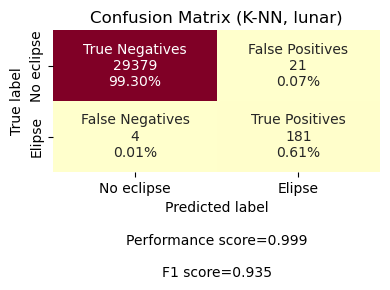

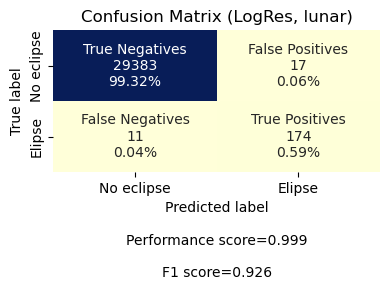

In [25]:
# predict with lunar
testl = dfl[bias_pos:]
test_labels_lunar = np.array(testl.pop('Is Eclipse'))
testl.set_index('Date', inplace=True)

# =======================================predictions with knn=============================================
predictions_l = knn_model.predict(testl)
accuracy_l = knn_model.score(testl, test_labels_lunar)
f1_l = f1_score(test_labels_lunar, predictions_l)
# print(f'Model Accuracy: {accuracy_l}')
# print(f'Precision: {precision_score(test_labels_lunar, predictions_l)}')
# print(f'Recall: {recall_score(test_labels_lunar, predictions_l)}')
# print(f'F1 Score: {f1_mlp}')

plot_cf_matrix(test_labels_lunar, predictions_l, accuracy_l, f1_l, label = 'K-NN, lunar', figsize = (4,3), cmap='YlOrRd')
plt.tight_layout()
plt.savefig('figures/knnlunar.pdf')

# =======================================predictions with lr=============================================
predictions_llr = logclas_model.predict(testl)
accuracy_llr = logclas_model.score(testl, test_labels_lunar)
f1_llr = f1_score(test_labels_lunar, predictions_llr)
# print(f'Model Accuracy: {accuracy_llr}')
# print(f'Precision: {precision_score(test_labels_lunar, predictions_llr)}')
# print(f'Recall: {recall_score(test_labels_lunar, predictions_llr)}')
# print(f'F1 Score: {f1_mlp}')

plot_cf_matrix(test_labels_lunar, predictions_llr, accuracy_llr, f1_llr, label = 'LogRes, lunar', figsize = (4,3), cmap='YlGnBu')
plt.tight_layout()
plt.savefig('figures/lrlunar.pdf')

Como se puede apreciar, los algoritmos parecen tener la capacidad de predecir eclipses lunares, esto sucede porque los modelos aprenden a identificar eclipses dada una separación adecuada, y dado que el algoritmo original para la obtención de separación, describe simplmente separaciones pequeñas en la bóveda celeste, el algoritmo tiene igualmente una buena precisión a la hora de predecir eclipses lunares.

Dado todo lo anterior, y teniendo en cuenta el error al determinar separaciones, todo lo anterior representa un reporte completo del funcionamiento de los modelos implementados, donde los modelos K-Nearest Neighbors y Random Forest resultan tener la mejor precisión a la hora de clasificar eventos. Estos modelos, sin embargo, según la discusión hecha, presentan rendimientos superiores al $98.4\%$ reportado según las matrices de confusión.

<!-- En general, el rendimiento del algoritmo resulta ser mucho mejor que el método de fuerza bruta calculando las separaciones de los cuerpos celestes. La generación de los datos de entrenamiento implementando este algoritmo, toma alrededor de 30 minutos para identificar eclipses solares y lunares en el intervalo de tiempo especificado anteriormente, lo cual resulta considerablemente mayor al tiempo empleado en el entrenamiento y la posterior identificación del conjunto de prueba utilizando las funciones de ```get_separation()``` dadas las fechas. -->